In [1]:
import tenpy
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
import re

from tenpy.simulations.post_processing import DataLoader, DataFiles

## loading & extracting relevant data

In [2]:
data_files = DataFiles()
data_files.load_from_folder("../run/conda/nthreads_1/")

loading ../run/conda/nthreads_1/bench_cons_Sz_sort_True.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_Sz_sort_False.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_None_sort_True.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_None_sort_False.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_None_sort_False.backup.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_None_sort_True.backup.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_Sz_sort_False.backup.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_Sz_sort_True.backup.h5 ... successful


In [3]:
data = data_files["../run/conda/nthreads_1/bench_cons_Sz_sort_True.h5"]
data

DataLoader(filename=PosixPath('../run/conda/nthreads_1/bench_cons_Sz_sort_True.h5'))

In [4]:
data.measurements.keys()

dict_keys(['<Sz>', 'bond_dimension', 'bond_energies', 'energy_MPO', 'entropy', 'measurement_index', 'walltime'])

In [5]:
data.measurements['bond_dimension'][-1]

array([   3,    9,   27,   81,  243,  677, 1304, 1651, 1945, 2048, 2048,
       2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
       2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
       2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
       2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
       2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
       2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
       2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048,
       2048, 2048, 1873, 1619, 1270,  684,  243,   81,   27,    9,    3])

In [6]:
np.max(data.measurements['bond_dimension'], axis=1)

array([   1,    9,   10,   10,   10,   32,   32,   32,   32,   64,   64,
         64,   64,  128,  128,  128,  128,  256,  256,  384,  384,  384,
        384,  512,  512,  768,  768,  768,  768, 1024, 1024, 1024, 1024,
       2048, 2048, 2048, 2048])

In [7]:
data.measurements['walltime']

array([7.83811331e-01, 2.84667683e+00, 4.86564350e+00, 6.75025654e+00,
       8.64746356e+00, 1.08859994e+01, 1.32267535e+01, 1.55685880e+01,
       1.79235201e+01, 2.05467432e+01, 2.32853456e+01, 2.60173101e+01,
       2.87596042e+01, 3.25312250e+01, 3.67503340e+01, 4.09731014e+01,
       4.51901016e+01, 5.25349925e+01, 6.12350919e+01, 7.54669924e+01,
       9.20637743e+01, 1.09490734e+02, 1.25871339e+02, 1.52999631e+02,
       1.82712469e+02, 2.48974753e+02, 3.29177660e+02, 4.08786526e+02,
       4.87820862e+02, 6.27930522e+02, 7.87280823e+02, 9.44716932e+02,
       1.10150399e+03, 1.73846179e+03, 2.63564042e+03, 3.49877934e+03,
       4.41854968e+03])

In [8]:
data.sim_params['algorithm_params']['chi_list']

{0: 10,
 4: 32,
 8: 64,
 12: 128,
 16: 256,
 18: 384,
 22: 512,
 24: 768,
 28: 1024,
 32: 2048}

In [9]:
walltime = data.measurements['walltime']
walltime[1:] - walltime[:-1]

array([  2.0628655 ,   2.01896667,   1.88461304,   1.89720702,
         2.23853588,   2.34075403,   2.34183455,   2.35493207,
         2.62322307,   2.7386024 ,   2.73196459,   2.74229407,
         3.77162075,   4.21910906,   4.22276735,   4.21700025,
         7.34489083,   8.70009947,  14.23190045,  16.59678197,
        17.42695999,  16.38060498,  27.12829185,  29.71283817,
        66.26228356,  80.20290709,  79.60886621,  79.03433561,
       140.10965991, 159.35030103, 157.4361093 , 156.78705335,
       636.95779991, 897.17863369, 863.13891888, 919.77034283])

In [10]:
def extract_time_per_sweep(data:DataLoader):
    """Extract arrays (chi, time_per_sweeps) from DataLoader"""
    chi_list = data.sim_params['algorithm_params']['chi_list']
    expected_chis = sorted(chi_list.values())[1:]
    actual_chi = np.max(data.measurements['bond_dimension'], axis=1)
    walltimes = data.measurements['walltime']
    delta_walltime = walltimes[1:] - walltimes[:-1]
    # exclude sweeps where we increased bond dimension
    keep = (actual_chi[1:] == actual_chi[:-1]) 
    actual_chi = actual_chi[1:][keep]
    delta_walltime = delta_walltime[keep]
    assert len(actual_chi) == len(delta_walltime)
    mean_per_sweep = []
    for chi in expected_chis:
        per_sweep = delta_walltime[actual_chi == chi]
        if len(per_sweep) > 0:
            mean_per_sweep.append(np.mean(per_sweep))
        else:
            mean_per_sweep.append(np.nan)
    return np.array(expected_chis), np.array(mean_per_sweep)

In [11]:
chis, time_per_sweep = extract_time_per_sweep(data)
chis, time_per_sweep

(array([  32,   64,  128,  256,  384,  512,  768, 1024, 2048]),
 array([  2.34584022,   2.73762035,   4.21962555,   8.70009947,
         16.80144898,  29.71283817,  79.61536964, 157.85782123,
        893.3626318 ]))

In [17]:
!ls ../itensor/timings*.out

../itensor/timings_nthreads_01_conserve_False.out
../itensor/timings_nthreads_01_conserve_True.out
../itensor/timings_nthreads_04_conserve_False.out
../itensor/timings_nthreads_04_conserve_True.out


In [18]:
def read_itensor_output(filename, expected_header="# sweep maxlinkdim walltime"):
    """Given a filename of a timing_*.txt file in ../itensor/, return `chis, timings`."""
    with open(filename, 'r') as f:
        lines = f.readlines()
    header = lines.pop(0)[:-1] # without newline
    if header != expected_header:
        raise ValueError(f"unexpected header reading {filename}:\n"
                         f"expected {expected_header!r}, got {header}")
    last_n = 0
    last_chi = 0
    chis = []
    times = []
    current_times_avg = []
    last_walltime = 0.
    for line in lines:
        n, chi, walltime = line.split()
        n = int(n)
        chi = int(chi)
        walltime = float(walltime)
        assert n == last_n + 1  # TODO: multiple results in one file?
        last_n = n
        if chi == last_chi:
            current_times_avg.append(walltime - last_walltime)
        else:
            if len(current_times_avg) > 0:
                chis.append(last_chi)
                times.append(np.mean(current_times_avg))
            last_chi = chi
            current_times_avg = [] # don't include timings of sweeps where chi changed
        last_walltime = walltime
    if len(current_times_avg) > 0:
        chis.append(last_chi)
        times.append(np.mean(current_times_avg))
    return np.array(chis), np.array(times)

In [19]:
read_itensor_output("../itensor/timings_nthreads_01_conserve_False.out")

(array([ 32,  64, 128, 256, 384]),
 array([  1.01112795,   3.29259205,  15.80931997,  85.67291713,
        283.3877461 ]))

## Main time/sweep vs chi plot for 1D DMRG benchmarks 

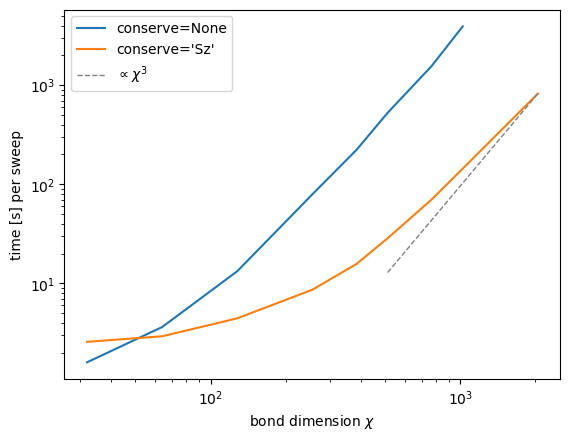

In [20]:
files = ["../run/conda/nthreads_1/bench_cons_None_sort_True.h5",
         "../run/conda/nthreads_1/bench_cons_Sz_sort_False.h5",
        ]

labels = ['conserve=None', "conserve='Sz'"]

plt.figure()
for file, lbl in zip(files,labels):
    chis, time_per_sweep = extract_time_per_sweep(data_files[file])
    plt.plot(chis, time_per_sweep, label=lbl)

chi_fit = np.array([512, 2048])
plt.plot(chi_fit, chi_fit**3 * (time_per_sweep[-1]/chis[-1]**3), linestyle='--', color='gray', linewidth=1., label=r"$\propto \chi^3$")
plt.legend()
plt.ylabel('time [s] per sweep')
plt.xlabel(r'bond dimension $\chi$')
plt.yscale('log')
plt.xscale('log')



## comparing TeNPy vs ITensor

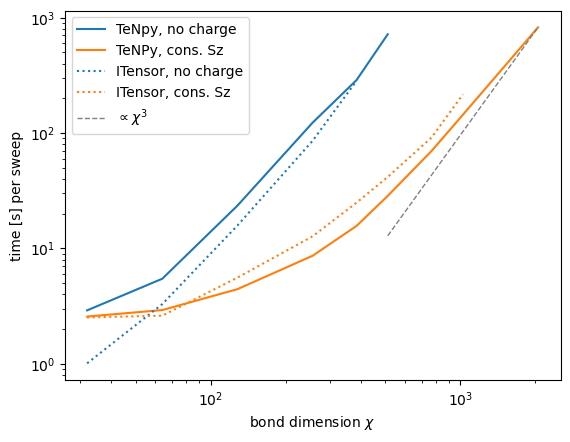

In [45]:
files = ["../run/conda/nthreads_1/bench_cons_None_sort_False.h5",
         "../run/conda/nthreads_1/bench_cons_Sz_sort_False.h5",
        ]
labels = ["TeNpy, no charge", "TeNPy, cons. Sz"]
linestyles = []

plt.figure()
for file, lbl in zip(files, labels):
    chis, time_per_sweep = extract_time_per_sweep(data_files[file])
    linestyle, = plt.plot(chis, time_per_sweep, label=lbl)
    linestyles.append(linestyle)

itensor_files = ["../itensor/timings_nthreads_01_conserve_False.out",
                 "../itensor/timings_nthreads_01_conserve_True.out"]
itensor_labels = ["ITensor, no charge", "ITensor, cons. Sz"]
for file, lbl, prev_style in zip(itensor_files, itensor_labels, linestyles):
    i_chis, i_time_per_sweep = read_itensor_output(file)
    plt.plot(i_chis, i_time_per_sweep, color=prev_style.get_color(), linestyle=':', label=lbl)


chi_fit = np.array([512, 2048])
plt.plot(chi_fit, chi_fit**3 * (time_per_sweep[-1]/chis[-1]**3), linestyle='--', color='gray', linewidth=1., label=r"$\propto \chi^3$")
plt.legend(loc='upper left')
plt.ylabel('time [s] per sweep')
plt.xlabel(r'bond dimension $\chi$')
plt.yscale('log')
plt.xscale('log')

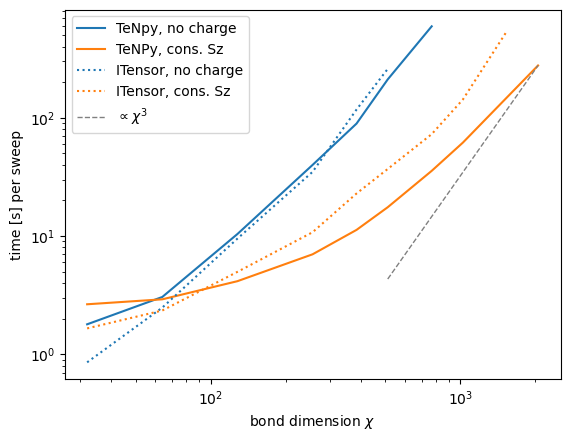

In [44]:

files = ["../run/conda/nthreads_4/bench_cons_None_sort_False.h5",
         "../run/conda/nthreads_4/bench_cons_Sz_sort_False.h5",
        ]
labels = ["TeNpy, no charge", "TeNPy, cons. Sz"]
linestyles = []

plt.figure()
for file, lbl in zip(files, labels):
    chis, time_per_sweep = extract_time_per_sweep(data_files[file])
    linestyle, = plt.plot(chis, time_per_sweep, label=lbl)
    linestyles.append(linestyle)

itensor_files = ["../itensor/timings_nthreads_04_conserve_False.out",
                 "../itensor/timings_nthreads_04_conserve_True.out"]
itensor_labels = ["ITensor, no charge", "ITensor, cons. Sz"]
for file, lbl, prev_style in zip(itensor_files, itensor_labels, linestyles):
    i_chis, i_time_per_sweep = read_itensor_output(file)
    plt.plot(i_chis, i_time_per_sweep, color=prev_style.get_color(), linestyle=':', label=lbl)




chi_fit = np.array([512, 2048])
plt.plot(chi_fit, chi_fit**3 * (time_per_sweep[-1]/chis[-1]**3), linestyle='--', color='gray', linewidth=1., label=r"$\propto \chi^3$")
plt.legend(loc='upper left')
plt.ylabel('time [s] per sweep')
plt.xlabel(r'bond dimension $\chi$')
plt.yscale('log')
plt.xscale('log')

In [23]:
!ls ../run/conda/nthreads_4/

bench_1D_DMRG.3940907_4294967294.out  bench_cons_None_sort_False.log
bench_1D_DMRG.config.yml	      bench_cons_Sz_sort_False.backup.h5
bench_1D_DMRG.slurm.sh		      bench_cons_Sz_sort_False.h5
bench_cons_None_sort_False.backup.h5  bench_cons_Sz_sort_False.log
bench_cons_None_sort_False.h5


## Fancy plot for paper

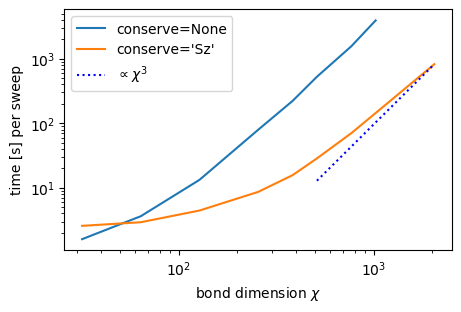

In [24]:
files = ["../run/conda/nthreads_1/bench_cons_None_sort_True.h5",
         "../run/conda/nthreads_1/bench_cons_Sz_sort_False.h5",
        ]

labels = ['conserve=None', "conserve='Sz'"]

figwidth = 5

plt.figure(figsize=(figwidth, figwidth/1.6))
for file, lbl in zip(files,labels):
    chis, time_per_sweep = extract_time_per_sweep(data_files[file])
    plt.plot(chis, time_per_sweep, label=lbl)

chi_fit = np.array([512, 2048])
plt.plot(chi_fit, chi_fit**3 * (time_per_sweep[-1]/chis[-1]**3), 'b:', label=r"$\propto \chi^3$")
plt.legend()
plt.ylabel('time [s] per sweep')
plt.xlabel(r'bond dimension $\chi$')
plt.yscale('log')
plt.xscale('log')

## checking DMRG timings for more cases

In [25]:
def plot_vs_chi(files, labels, fit=True):
    plt.figure(figsize=(5,3))
    for file, lbl in zip(files,labels):
        chis, time_per_sweep = extract_time_per_sweep(data_files[file])
        plt.plot(chis, time_per_sweep, label=lbl)

    if fit:
        chi_fit = np.array([chis[-1]//4, chis[-1]])
        plt.plot(chi_fit, chi_fit**3 * (time_per_sweep[-1]/chis[-1]**3), linestyle='--', color='gray', linewidth=1., label=r"$\propto \chi^3$")
    plt.legend()
    plt.ylabel('time [s] per sweep')
    plt.xlabel(r'bond dimension $\chi$')
    plt.yscale('log')
    plt.xscale('log')

Text(0.5, 1.0, "sort_MPO_leg doesn't matter in this case")

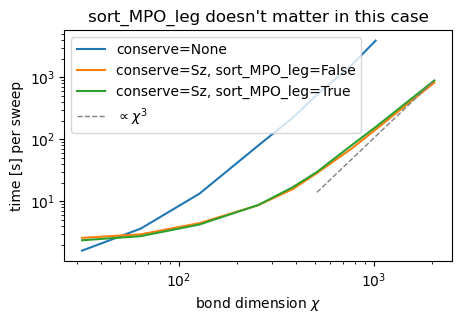

In [46]:
plot_vs_chi(['../run/conda/nthreads_1/bench_cons_None_sort_True.h5',
             '../run/conda/nthreads_1/bench_cons_Sz_sort_False.h5',
             '../run/conda/nthreads_1/bench_cons_Sz_sort_True.h5',
            ],
            ['conserve=None',
             'conserve=Sz, sort_MPO_leg=False',
             'conserve=Sz, sort_MPO_leg=True'])
plt.title("sort_MPO_leg doesn't matter in this case")

Text(0.5, 1.0, 'comparison pip vs conda installation')

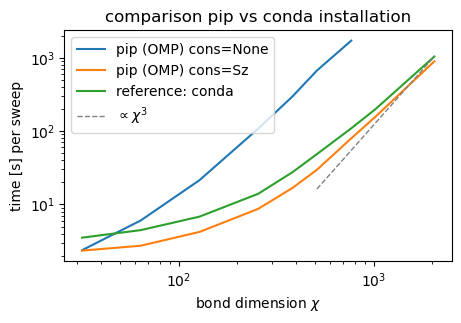

In [47]:
plot_vs_chi(['../run/pip/nthreads_1/bench_cons_None_sort_True.h5',
             '../run/conda/nthreads_1/bench_cons_Sz_sort_True.h5',
             '../run/pip/nthreads_1/bench_cons_Sz_sort_False.h5',
             '../run/conda/nthreads_1/bench_cons_Sz_sort_True.h5',
            ],
            ['pip (OMP) cons=None',
             'pip (OMP) cons=Sz',
             'reference: conda'])
plt.title("comparison pip vs conda installation")

Text(0.5, 1.0, 'N_threads=16')

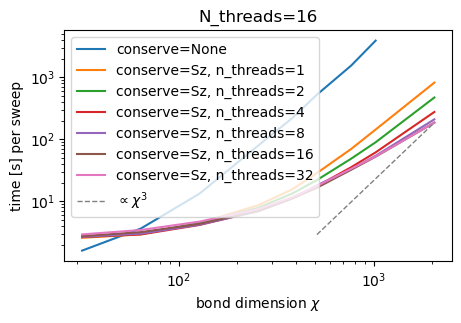

In [48]:
plot_vs_chi(['../run/conda/nthreads_1/bench_cons_None_sort_True.h5',
             '../run/conda/nthreads_1/bench_cons_Sz_sort_False.h5',
             '../run/conda/nthreads_2/bench_cons_Sz_sort_False.h5',
             '../run/conda/nthreads_4/bench_cons_Sz_sort_False.h5',
             '../run/conda/nthreads_8/bench_cons_Sz_sort_False.h5',
             '../run/conda/nthreads_16/bench_cons_Sz_sort_False.h5',
             '../run/conda/nthreads_32/bench_cons_Sz_sort_False.h5',
            ],
            ['conserve=None',
             'conserve=Sz, n_threads=1',
             'conserve=Sz, n_threads=2',
             'conserve=Sz, n_threads=4',
             'conserve=Sz, n_threads=8',
             'conserve=Sz, n_threads=16',
             'conserve=Sz, n_threads=32',
])
plt.title("N_threads=16")

In [49]:
!ls ../run/conda_nohyperthreading/*/*.h5

../run/conda_nohyperthreading/n_threads_01/bench_cons_Sz_sort_False.h5
../run/conda_nohyperthreading/n_threads_02/bench_cons_Sz_sort_False.h5
../run/conda_nohyperthreading/n_threads_04/bench_cons_Sz_sort_False.h5
../run/conda_nohyperthreading/n_threads_08/bench_cons_Sz_sort_False.h5
../run/conda_nohyperthreading/n_threads_16/bench_cons_Sz_sort_False.h5
../run/conda_nohyperthreading/n_threads_32/bench_cons_Sz_sort_False.h5


[(PosixPath('../run/conda_nohyperthreading/n_threads_01/bench_cons_Sz_sort_False.h5'),
  'n_threads_01'),
 (PosixPath('../run/conda_nohyperthreading/n_threads_02/bench_cons_Sz_sort_False.h5'),
  'n_threads_02'),
 (PosixPath('../run/conda_nohyperthreading/n_threads_04/bench_cons_Sz_sort_False.h5'),
  'n_threads_04'),
 (PosixPath('../run/conda_nohyperthreading/n_threads_08/bench_cons_Sz_sort_False.h5'),
  'n_threads_08'),
 (PosixPath('../run/conda_nohyperthreading/n_threads_16/bench_cons_Sz_sort_False.h5'),
  'n_threads_16'),
 (PosixPath('../run/conda_nohyperthreading/n_threads_32/bench_cons_Sz_sort_False.h5'),
  'n_threads_32')]

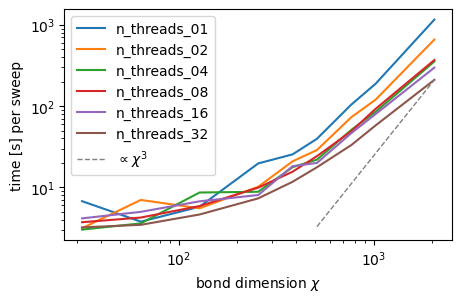

In [50]:
files = list(Path("../run/conda_nohyperthreading").glob("*/*.h5"))
labels = [re.match(r".+/(n_threads_[0-9]+)/.+", str(file)).groups()[0] 
          for file in files]
plot_vs_chi(files, labels)
list(zip(files, labels))

[(PosixPath('../run/conda_hyperthreading/n_threads_01/bench_cons_Sz_sort_False.h5'),
  'n_threads_01'),
 (PosixPath('../run/conda_hyperthreading/n_threads_02/bench_cons_Sz_sort_False.h5'),
  'n_threads_02'),
 (PosixPath('../run/conda_hyperthreading/n_threads_04/bench_cons_Sz_sort_False.h5'),
  'n_threads_04'),
 (PosixPath('../run/conda_hyperthreading/n_threads_08/bench_cons_Sz_sort_False.h5'),
  'n_threads_08'),
 (PosixPath('../run/conda_hyperthreading/n_threads_16/bench_cons_Sz_sort_False.h5'),
  'n_threads_16'),
 (PosixPath('../run/conda_hyperthreading/n_threads_32/bench_cons_Sz_sort_False.h5'),
  'n_threads_32'),
 (PosixPath('../run/conda_hyperthreading/n_threads_64/bench_cons_Sz_sort_False.h5'),
  'n_threads_64')]

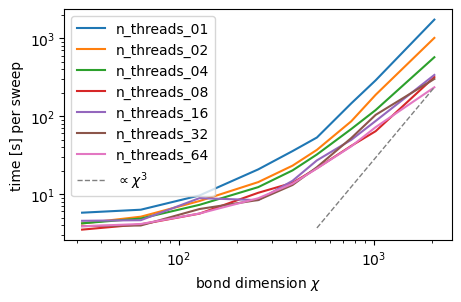

In [51]:
files = list(Path("../run/conda_hyperthreading").glob("*/*.h5"))
labels = [re.match(r".+/(n_threads_[0-9]+)/.+", str(file)).groups()[0] 
          for file in files]
plot_vs_chi(files, labels)
list(zip(files, labels))

[(PosixPath('../run/pip_threads/nthreads_32/bench_cons_None_sort_False.h5'),
  'nthreads_32'),
 (PosixPath('../run/pip_threads/nthreads_16/bench_cons_None_sort_False.h5'),
  'nthreads_16'),
 (PosixPath('../run/pip_threads/nthreads_8/bench_cons_None_sort_False.h5'),
  'nthreads_8'),
 (PosixPath('../run/pip_threads/nthreads_4/bench_cons_None_sort_False.h5'),
  'nthreads_4'),
 (PosixPath('../run/pip_threads/nthreads_2/bench_cons_None_sort_False.h5'),
  'nthreads_2'),
 (PosixPath('../run/pip_threads/nthreads_1/bench_cons_None_sort_False.h5'),
  'nthreads_1')]

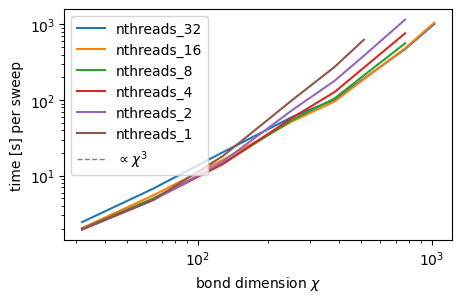

In [52]:
files = list(Path("../run/pip_threads/").glob("*/*.h5"))
labels = [re.match(r".+/(nthreads_[0-9]+)/.+", str(file)).groups()[0] 
          for file in files]
plot_vs_chi(files, labels)
list(zip(files, labels))

In [53]:
!ls -l ../run/pip_threads/nthreads_64/bench_cons_None_sort_False.h5

ls: cannot access '../run/pip_threads/nthreads_64/bench_cons_None_sort_False.h5': No such file or directory


[(PosixPath('../run/conda_global_omp/nthreads_32/bench_cons_None_sort_False.h5'),
  'nthreads_32'),
 (PosixPath('../run/conda_global_omp/nthreads_16/bench_cons_None_sort_False.h5'),
  'nthreads_16'),
 (PosixPath('../run/conda_global_omp/nthreads_8/bench_cons_None_sort_False.h5'),
  'nthreads_8'),
 (PosixPath('../run/conda_global_omp/nthreads_4/bench_cons_None_sort_False.h5'),
  'nthreads_4'),
 (PosixPath('../run/conda_global_omp/nthreads_2/bench_cons_None_sort_False.h5'),
  'nthreads_2'),
 (PosixPath('../run/conda_global_omp/nthreads_1/bench_cons_None_sort_False.h5'),
  'nthreads_1')]

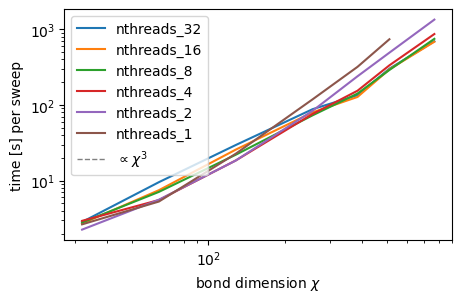

In [54]:
files = list(Path("../run/conda_global_omp/").glob("*/*.h5"))
labels = [re.match(r".+/(nthreads_[0-9]+)/.+", str(file)).groups()[0] 
          for file in files]
plot_vs_chi(files, labels)
list(zip(files, labels))